# ARIMA

## Data Preparation

In [1]:
import pandas as pd
import pyarrow as pa

# Read chartevents_subset from parquet file to pandas data frame
chartevents_subset = pd.read_parquet('../data/chartevents_clean_values_and_thresholds_with_chunkid_65_resampled.parquet', engine='pyarrow')

In [2]:
PARAMETER = 220045
CHUNKS = ['296490.0_220045.0_2192-09-26 23:51:00','260223.0_220045.0_2156-08-06 17:46:00']

# Sampling rate of 1 data point per hour 
TRAIN = 60 # 60 * 1 h = 60 hour training period
TEST = 12 # 12 * 1 h = 12 hour testing period
STEP = 6 # move 6 * 1 h = 6 hours per step

In [3]:
# Subset data based on PARAMETER & CHUNKS
arima_data = chartevents_subset[
    (chartevents_subset["ITEMID"] == PARAMETER) & 
    (chartevents_subset.CHUNK_ID_FILLED_TH.isin(CHUNKS))
    ][['CHUNK_ID_FILLED_TH','CHARTTIME','ITEMID','VALUENUM_CLEAN']]
display(arima_data)

,CHUNK_ID_FILLED_TH,CHARTTIME,ITEMID,VALUENUM_CLEAN
3059308,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 17:00:00,220045.0,110.5
3059309,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 18:00:00,220045.0,108.0
3059310,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 19:00:00,220045.0,110.0
3059311,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 20:00:00,220045.0,107.0
3059312,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 21:00:00,220045.0,104.5
...,...,...,...,...
4918829,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 11:00:00,220045.0,97.0
4918830,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 12:00:00,220045.0,90.0
4918831,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 13:00:00,220045.0,88.0
4918832,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 14:00:00,220045.0,88.0


In [4]:
# Filter for chunks that have sufficient values to be used for training and testing the model
all_chunks_value_count = arima_data.CHUNK_ID_FILLED_TH.value_counts()
chunkid_filter = all_chunks_value_count[all_chunks_value_count >= (TRAIN + TEST)].index
arima_data = arima_data[arima_data.CHUNK_ID_FILLED_TH.isin(chunkid_filter)]
display(arima_data)

,CHUNK_ID_FILLED_TH,CHARTTIME,ITEMID,VALUENUM_CLEAN
3059308,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 17:00:00,220045.0,110.5
3059309,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 18:00:00,220045.0,108.0
3059310,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 19:00:00,220045.0,110.0
3059311,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 20:00:00,220045.0,107.0
3059312,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 21:00:00,220045.0,104.5
...,...,...,...,...
4918829,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 11:00:00,220045.0,97.0
4918830,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 12:00:00,220045.0,90.0
4918831,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 13:00:00,220045.0,88.0
4918832,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 14:00:00,220045.0,88.0


In [5]:
# Create new MINUTES_SINCE_FIRST_RECORD column containing the time difference that has passed since the first timestamp of the measurement series.
import numpy as np
arima_data['MINUTES_SINCE_FIRST_RECORD'] = arima_data.groupby('CHUNK_ID_FILLED_TH')['CHARTTIME'].transform(lambda x: (x - x.min())/np.timedelta64(1,'m'))
# Alternative for hours instead of minutes
# arima_data['HOURS_SINCE_FIRST_RECORD'] = arima_data.groupby('CHUNK_ID_FILLED_TH')['CHARTTIME'].transform(lambda x: (x - x.min())/np.timedelta64(1,'h'))
display(arima_data)

,CHUNK_ID_FILLED_TH,CHARTTIME,ITEMID,VALUENUM_CLEAN,MINUTES_SINCE_FIRST_RECORD
3059308,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 17:00:00,220045.0,110.5,0.0
3059309,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 18:00:00,220045.0,108.0,60.0
3059310,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 19:00:00,220045.0,110.0,120.0
3059311,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 20:00:00,220045.0,107.0,180.0
3059312,260223.0_220045.0_2156-08-06 17:46:00,2156-08-06 21:00:00,220045.0,104.5,240.0
...,...,...,...,...,...
4918829,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 11:00:00,220045.0,97.0,43920.0
4918830,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 12:00:00,220045.0,90.0,43980.0
4918831,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 13:00:00,220045.0,88.0,44040.0
4918832,296490.0_220045.0_2192-09-26 23:51:00,2192-10-27 14:00:00,220045.0,88.0,44100.0


In [7]:
# Change data structure
# Create a list containing one element for each chunk, which are of type pandas series.
# Each of these series includes the measured values of the chunk with the MINUTES_SINCE_FIRST_RECORD as index.
# The data structure is transposed, so to speak, so that the MINUTES_SINCE_FIRST_RECORD that were previously in rows now serve as 'columns' (not literally; they are in the index of the series).

# MINUTES_SINCE_FIRST_RECORD  |     0 |    60 |   120 | ...
# ----------------------------------------------------- ...
# firstChunk                  |  95.0 |  90.5 |  91.0 | ...
# secondChunk                 | 110.5 | 108.0 | 110.0 | ...
# ...

# Set up list that will contain the chunk value series transformed as described above.
list_of_chunk_value_series = []

for chunkid in chunkid_filter:

    chunk_value_series = arima_data[arima_data.CHUNK_ID_FILLED_TH == chunkid].copy()
    chunk_value_series.set_index('MINUTES_SINCE_FIRST_RECORD', inplace=True)
    chunk_value_series.sort_index(inplace=True)    
    list_of_chunk_value_series.append(chunk_value_series['VALUENUM_CLEAN'])


In [30]:
# The step of creating multiple test & training sets per measurement series may be  skipped, as we currently see no use for it in the context of ARIMA.

# Create multiple test & training sets per chunk value series
chunk_value_series_with_test_and_train = pd.DataFrame(columns=["SUB_CHUNK_ID", "TRAIN_LIST","TEST_LIST"])

for i, chunk_value_series in enumerate(list_of_chunk_value_series):

    # For each starting point of a new train/test section of this chunk (from 0 to total length of this chunk value series - (TRAIN + TEST)) move STEPS 
    for start in range(0, len(chunk_value_series) - (TRAIN + TEST), STEP):

        sub_chunk_id = str(i)+str(start)
        train_list = chunk_value_series[start : start+TRAIN]
        test_list = chunk_value_series[start+TRAIN : start+TRAIN+TEST]
        a_new_row= {"SUB_CHUNK_ID":sub_chunk_id,"TRAIN_LIST":train_list,"TEST_LIST":test_list}
        a_new_row_series = pd.Series(a_new_row, name=sub_chunk_id)
        chunk_value_series_with_test_and_train = chunk_value_series_with_test_and_train.append(a_new_row_series)
        # chunk_value_series_with_test_and_train.reset_index(drop=True, inplace=True)

display(chunk_value_series_with_test_and_train)

,SUB_CHUNK_ID,TRAIN_LIST,TEST_LIST
00,00,MINUTES_SINCE_FIRST_RECORD 0.0 95.0 60.0 ...,MINUTES_SINCE_FIRST_RECORD 60.0 90.5 Name: ...
06,06,MINUTES_SINCE_FIRST_RECORD 60.0 90.5 Name: ...,"Series([], Name: VALUENUM_CLEAN, dtype: float64)"
012,012,MINUTES_SINCE_FIRST_RECORD 60.0 90.5 Name: ...,"Series([], Name: VALUENUM_CLEAN, dtype: float64)"
018,018,MINUTES_SINCE_FIRST_RECORD 60.0 90.5 Name: ...,"Series([], Name: VALUENUM_CLEAN, dtype: float64)"
024,024,MINUTES_SINCE_FIRST_RECORD 60.0 90.5 Name: ...,"Series([], Name: VALUENUM_CLEAN, dtype: float64)"
...,...,...,...
0642,0642,MINUTES_SINCE_FIRST_RECORD 660.0 84.0 Name:...,"Series([], Name: VALUENUM_CLEAN, dtype: float64)"
0648,0648,MINUTES_SINCE_FIRST_RECORD 660.0 84.0 Name:...,MINUTES_SINCE_FIRST_RECORD 720.0 75.0 Name:...
0654,0654,MINUTES_SINCE_FIRST_RECORD 660.0 84.0 Name:...,MINUTES_SINCE_FIRST_RECORD 720.0 75.0 Name:...
0660,0660,MINUTES_SINCE_FIRST_RECORD 660.0 84.0 720.0...,MINUTES_SINCE_FIRST_RECORD 720.0 75.0 Name:...


## ARIMA Forecasting for Single Time Series

Perform ARIMA analysis and prediction for a single manually selected time series, i.e. a single chunk and thus a single parameter.

In [31]:
# Conduct ARIMA for single times series

# Used resources:
# https://kanoki.org/2020/04/30/time-series-analysis-and-forecasting-with-arima-python/
# https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

# Select single times series
data = pd.DataFrame(list_of_chunk_value_series[0])

# Find the best fit ARIMA model for the univariate time series data using auto_arima

# I assume that our value series are not seasonal (to be checked)
# Therefore, I set seasonal=False and m=1
# See also https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

from pmdarima.arima import auto_arima
auto_arima_model = auto_arima(data, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=1,
                            start_P=0, seasonal=False,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(auto_arima_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4578.018, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4584.449, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4582.099, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4580.322, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4582.588, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4548.611, Time=1.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4567.098, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4548.263, Time=1.82 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4563.601, Time=0.71 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4550.099, Time=2.29 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4548.705, Time=1.30 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4546.344, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4546.686, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4561.747, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0]          

In [32]:
# Train Test Split
split_position = round((len(data)*80)/100) # Position of the row which is positioned at 80% of the total number of rows
train = data.iloc[:split_position]
test = data.iloc[split_position:]

print("Total data length:",len(data))
print("Train data length:",len(train))
print("Test data length:",len(test))

Total data length: 737
Train data length: 590
Test data length: 147


In [33]:
# Train the Model
auto_arima_model.fit(train)

ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [34]:
forecast = auto_arima_model.predict(len(test))
# This returns an array of predictions:
print(forecast)

[65.25235115 66.04985294 66.61383274 67.04746161 67.3961831  67.6767695
 67.90216873 68.083206   68.22861886 68.34541859 68.43923539 68.51459162
 68.57511982 68.62373773 68.66278897 68.694156   68.71935086 68.73958806
 68.75584314 68.76889967 68.77938703 68.78781076 68.79457694 68.80001172
 68.80437708 68.80788346 68.81069988 68.81296211 68.81477919 68.81623872
 68.81741106 68.81835271 68.81910907 68.8197166  68.82020458 68.82059655
 68.82091138 68.82116427 68.82136739 68.82153054 68.82166159 68.82176686
 68.82185141 68.82191932 68.82197387 68.82201769 68.82205288 68.82208115
 68.82210386 68.82212209 68.82213674 68.82214851 68.82215796 68.82216555
 68.82217165 68.82217655 68.82218048 68.82218364 68.82218618 68.82218822
 68.82218986 68.82219117 68.82219223 68.82219308 68.82219376 68.82219431
 68.82219475 68.8221951  68.82219538 68.82219561 68.8221958  68.82219594
 68.82219606 68.82219616 68.82219623 68.82219629 68.82219634 68.82219638
 68.82219641 68.82219644 68.82219646 68.82219648 68.

In [35]:
# Reorganize set of predictions by creating a dataframe that contains forecast and then concatenating that with the original data.
forecast = pd.DataFrame(forecast,index = test.index,columns=['VALUENUM_PREDICTION'])

evaluation_data = pd.concat([test,forecast],axis=1)
display(evaluation_data)

,VALUENUM_CLEAN,VALUENUM_PREDICTION
MINUTES_SINCE_FIRST_RECORD,,
35400.0,65.0,65.252351
35460.0,63.0,66.049853
35520.0,82.0,66.613833
35580.0,86.0,67.047462
35640.0,83.0,67.396183
...,...,...
43920.0,97.0,68.822197
43980.0,90.0,68.822197
44040.0,88.0,68.822197


<AxesSubplot:xlabel='MINUTES_SINCE_FIRST_RECORD', ylabel='value'>

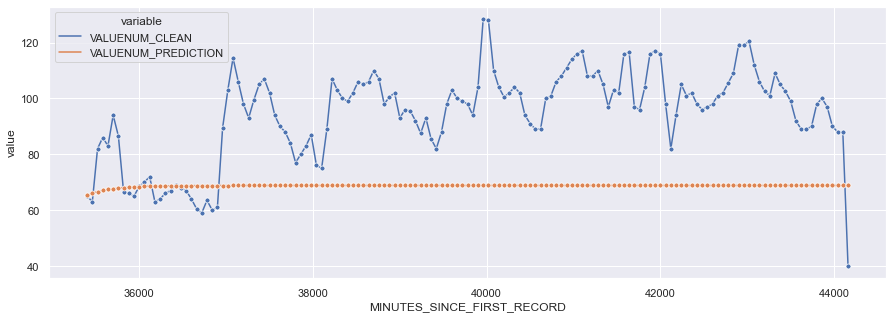

In [36]:
# Quick and dirty plot for testing purposes
import seaborn as sns
sns.set(rc={"figure.figsize":(15, 5)})
sns.lineplot(
    data=pd.melt(evaluation_data.reset_index(),'MINUTES_SINCE_FIRST_RECORD'), # Reshape data frame for seaborn
    x="MINUTES_SINCE_FIRST_RECORD",
    y="value",
    hue="variable",
    marker="o",
    markersize = 5
    )

<AxesSubplot:xlabel='MINUTES_SINCE_FIRST_RECORD', ylabel='value'>

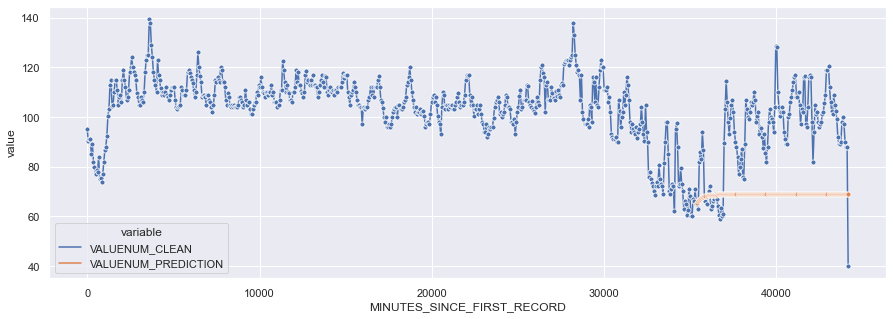

In [37]:
# Quick and dirty plot with training period
evaluation_data_with_train = pd.concat([train,test,forecast],axis=1)
import seaborn as sns
sns.set(rc={"figure.figsize":(15, 5)})
sns.lineplot(
    data=pd.melt(evaluation_data_with_train.reset_index(),'MINUTES_SINCE_FIRST_RECORD'), # Reshape data frame for seaborn
    x="MINUTES_SINCE_FIRST_RECORD",
    y="value",
    hue="variable",
    marker="o",
    markersize = 5
    )

In [ ]:
# Observation: prediction is pretty crappy
# No idea what the most likely reason is. I'll try it with ARIMA default settings.

4544.822157777377


<AxesSubplot:xlabel='MINUTES_SINCE_FIRST_RECORD', ylabel='value'>

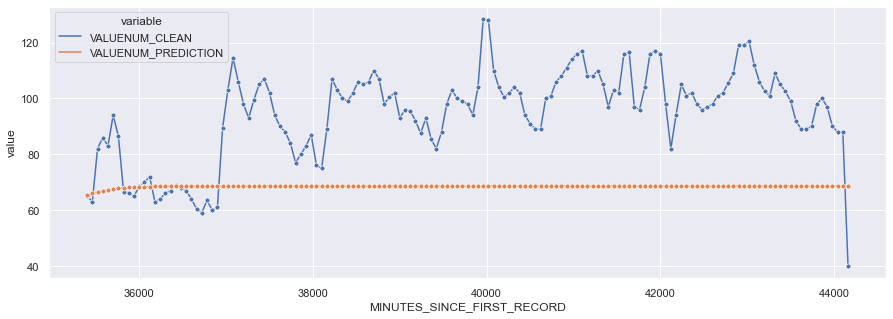

In [38]:
# Find the best fit ARIMA model for the univariate time series data using auto_arima
from pmdarima.arima import auto_arima
auto_arima_model = auto_arima(data)
print(auto_arima_model.aic())

# Train the Model
auto_arima_model.fit(train)

# Evaluate
forecast = auto_arima_model.predict(len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['VALUENUM_PREDICTION'])
evaluation_data = pd.concat([test,forecast],axis=1)

import seaborn as sns
sns.set(rc={"figure.figsize":(15, 5)})
sns.lineplot(
    data=pd.melt(evaluation_data.reset_index(),'MINUTES_SINCE_FIRST_RECORD'), # Reshape data frame for seaborn
    x="MINUTES_SINCE_FIRST_RECORD",
    y="value",
    hue="variable",
    marker="o",
    markersize = 5
    )

In [ ]:
# Observation: prediction is still crappy

## Conduct ARIMA based on all data

In [ ]:
# conduct arima
from progressbar import progressbar
import pmdarima as pm

condition = []
prediction = []
all_sub_chunk_ids = chunk_with_test_train.SUB_CHUNK_ID.value_counts()

for i, sub_chunk_id in enumerate(all_sub_chunk_ids):
    arima = pm.auto_arima(chunk_with_test_train['TRAIN_LIST'][i])
    forecast = arima.predict(TEST)

    condition.append(min(chunk_with_test_train["TEST_LIST"][i]) > 120)
    prediction.append(min(forecast) > 120)

In [ ]:
tp, tn, fp, fn = 0, 0, 0, 0

for cond, pred in zip(condition, prediction):
    if cond and pred:
        tp += 1
    if cond and not pred:
        fn += 1
    if not cond and pred:
        fp += 1
    if not cond and not pred:
        tn += 1

In [ ]:
print(f"TP = {tp}")
print(f"TN = {tn}")
print(f"FP = {fp}")
print(f"FN = {fn}")
print()
print(f"Sens = {tp/(tp+fn)} (recall)")
print(f"Spec = {tn/(tn+fp)}")
print(f"PPV  = {tp/(tp+fp)} (precision)")